In [1]:
import os
import sys
import h5py
import shutil
import csv
import pandas as pd
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table,coordinates
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.visualization import make_lupton_rgb
from astroquery.vizier import Vizier
from collections import Counter
from tensorflow import keras
from astropy.wcs import WCS,utils
import matplotlib.pyplot as plt

In [2]:
label_dir = "/home/anahoban/projects/def-sfabbro/anahoban/lensing/GravitationalLensing/Code/Batch Loading/Currently used/labels/"

## Want to include more candidates:
1. Make list of all candidates coordinates
2. Make list of all ring galaxies
3. Get corresponding tiles
4. Create 200x200 pixels cutouts in all available bands and store them in dataset
5. Visualize them and pick best

# 1. Gathering all known lenses: in currently used/labels/new lenses
- HSC-SSP: https://arxiv.org/abs/2107.07829                              from vizier
- HSC: https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..87C/abstract  chan2020
- HSC: https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.3156J/abstract    1 lens: HSC J0904–0102 : '09:04:29.75 −01:02:28.26'
- SDSS: https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.4617T/abstract   talbot2021: SILO file
- DESI: https://ui.adsabs.harvard.edu/abs/2021arXiv210900014R/abstract   rojas2021
- CFIS papers :                                                          savary2021: '/home/anahoban/projects/rrg-kyi/astro/lenses/unions_paper_lenses.csv'
- masterlens DB or new Swiss database ?

### Create new file with all new lens candidates: 'labels/new_lenses.csv'
# Don't need to run this if file is already created

In [41]:
def convert_to_float(objects_list, ra_col, dec_col):

    for i, coord in enumerate(objects_list):
        for col in [ra_col, dec_col]:
            try: 
                objects_list[i][col] = float(coord[col])
            except:
                objects_list[i][col] = -float(coord[col][1:])
    return objects_list

In [42]:
from astropy.table import Table
Talbot_table = Table.read("/home/anahoban/scratch/" + 'silo_eboss_detections-1.0.1.fits' , memmap=True)
talbot_df = Talbot_table['CATALOG_ID','RA','DEC','TOTAL_GRADE'].to_pandas()

In [43]:
keys = ['Names', 'RA', 'DEC', 'Classification'] 

#chan
chan = open(label_dir + '/new lenses/chan2020.txt', 'r+')
lines = chan.read().split('\n')
chan.close()

chan_data = [line.split(' ')[:4] for line in lines[1:]]
convert_to_float(chan_data,1,2)
chan_df = pd.DataFrame(chan_data, columns = keys)

#rojas
rojas = open(label_dir + '/new lenses/rojas2021.txt', 'r+')
lines = rojas.read().split('\n')
rojas.close()

rojas_data = [line.split(' ')[1:5] for line in lines[1:]]
convert_to_float(rojas_data,1,2)
rojas_df = pd.DataFrame(rojas_data, columns = keys)

#savary
savary = open(label_dir + '/new lenses/savary2021.txt', 'r+')
lines = savary.read().split('\n')
savary.close()

savary_data = [line.split(' ')[1:5] for line in lines[1:]]
convert_to_float(savary_data,1,2)
savary_df = pd.DataFrame(savary_data, columns = keys)

#Jaelani (1 lens)
ra_dec = coordinates.SkyCoord('09:04:29.75 −01:02:28.26', unit=(u.hourangle, u.deg))
jae_data = [('HSCJ0904–0102', ra_dec.ra.deg, ra_dec.dec.deg, 3.0)]

#talbot
talbot_df.rename(columns={'CATALOG_ID': keys[0], 'TOTAL_GRADE': keys[-1]})

,Names,RA,DEC,Classification
0,0,30.799484,-0.376353,b'B-'
1,1,32.393986,0.246297,b'B+'
2,2,37.707367,-0.543282,b'B-'
3,3,37.892769,0.412356,b'A+'
4,4,36.530914,1.171299,b'A+'
...,...,...,...,...
1546,1546,166.835144,29.384171,b'C-'
1547,1547,177.766769,30.591610,b'A+'
1548,1548,353.941803,9.510032,b'C-'
1549,1549,356.144073,10.454764,b'A+'


In [44]:
#canameras lenses
lenses_cana = Vizier.get_catalogs(catalog="J/A+A/644/A163")[0]

#extracting relevent columns

cana_names = list(lenses_cana['Name'])#,'RAJ2000','DEJ2000','Grade']]
cana_ra = np.array(list(lenses_cana['RAJ2000']))
cana_dec = np.array(list(lenses_cana['DEJ2000']))
cana_grade = list(lenses_cana['Grade'])

#converting to ra&dec
ra_dec_degrees = [coordinates.SkyCoord( (cana_ra[i] + ' ' + cana_dec[i]),unit=(u.hourangle, u.deg)) for i in range(0, len(cana_ra))]
cana_ra_deg= [ coord.ra.deg  for coord in ra_dec_degrees]
cana_dec_deg= [ coord.dec.deg for coord in ra_dec_degrees]


cana_data = [ (cana_names[i], cana_ra_deg[i], cana_dec_deg[i], cana_grade[i]) for i in range(len(cana_names)) ]


jae_cana_df = pd.DataFrame(cana_data+jae_data, columns = keys)

In [45]:
new_cand_dfs = [chan_df, rojas_df, savary_df, jae_cana_df, talbot_df]
all_new_lenses = pd.concat(new_cand_dfs)

#save new lenses to csv
all_new_lenses.to_csv(label_dir + 'new_lenses.csv')

### Combine with previous candidates (ra_dec.csv) and get tile

In [46]:
keys = ['Names', 'RA', 'DEC', 'Classification', 'Tile', 'X', 'Y'] 
new_list = pd.read_csv(label_dir + 'new_lenses.csv')[keys[:-3]]
old_list = pd.read_csv(label_dir + 'ra_dec.csv')

old_with_xy = pd.DataFrame([ ['previous', old_list['ra'][i],old_list['dec'][i], '--', 'tbd', 'tbd', 'tbd' ] for i in range(len(old_list))], columns = keys)
new_with_xy = pd.DataFrame([ [new_list['Names'][i], new_list['RA'][i], new_list['DEC'][i], new_list['Classification'][i], 'tbd', 'tbd', 'tbd' ] for i in range(len(new_list))], columns = keys)

#save in file
all_lenses = pd.concat([new_with_xy, old_with_xy])
#all_lenses.to_csv(label_dir + 'all_lenses.csv')

# 2. Add ring galaxies: in currently used/labels/new lenses/rings
- PanSTARRS: https://ui.adsabs.harvard.edu/abs/2017ApJS..231....2T/abstract 

    185 Ring Galaxy Candidates Identified Automatically
    
    18 Collisional Ring Galaxies from (Madore et al. 2009) That Are Inside the Footprint of PanSTARRS DR1
    
- SDSS: https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3767S/abstract

    443 Ring galaxies in SDSS
    
- DESI (same paper as in 1) <--can't find the cat

In [9]:
ring_ps1 = 'rings/ringsPS1.txt'
ring_sdss = 'rings/ringsSDSS.txt'
keys = ['Name', 'RA', 'DEC']

In [29]:
#PS1
rings = open(label_dir + ring_ps1, 'r+')
lines = rings.read().split('\n')
rings.close()

rings_ps1_data = [line.split(' ')[1:4] for line in lines[1:]]
convert_to_float(rings_ps1_data,1,2)
rings_ps1_df = pd.DataFrame(data = rings_ps1_data[:202], columns = keys)

#sdss
rings = open(label_dir + ring_sdss, 'r+')
lines = rings.read().split('\n')
rings.close()

rings_sdss_data = [line.split(' ')[:3] for line in lines[1:]] + [line.split(' ')[3:6] for line in lines[1:]] + [line.split(' ')[6:9] for line in lines[1:]] + [line.split(' ')[9:] for line in lines[1:]]
convert_to_float(rings_sdss_data[:-1],1,2)
rings_sdss_df = pd.DataFrame(data = rings_sdss_data[:-1], columns = keys)


In [30]:
rings_df = [rings_ps1_df, rings_sdss_df]
all_rings = pd.concat(rings_df)
all_rings.to_csv(label_dir + 'all_rings.csv')

## Cross Match lenses and rings catalogues and remove duplicates
### Note: there is no duplicate for now!

In [92]:
#0.1857 arcsecond per pixel
#so 1 arcsec error gives (in degrees):
err = 1/3600

In [93]:
#get catalogues and remove iduplicates
all_rings  = pd.read_csv(label_dir + 'all_rings.csv').drop_duplicates(subset=['RA', 'DEC'], keep='first')
all_lenses = pd.read_csv(label_dir + 'all_lenses.csv').drop_duplicates(subset=['RA', 'DEC'], keep='first')


#plot on sky to see if there are other duplicates**

In [94]:
rings_array  = np.array(all_rings[['RA','DEC']])
lenses_array = np.array(all_lenses[['RA','DEC']])

In [95]:
print('there are', len(lenses_array), 'unique lenses')

there are 7146 unique lenses


In [96]:
lens_is_ring = []
for ring in rings_array:
    diff_ra, diff_dec = zip(*(lenses_array-ring))
    
    for i in range(len(diff_ra)):
        if np.abs(diff_ra[i]) <= err and np.abs(diff_dec[i]) <= err:
            print(lenses_array[i], ring)
            lens_is_ring.append((lenses_array[i]) )

In [97]:
print('there are', len(lens_is_ring), 'lenses that are rings')

there are 0 lenses that are rings


# 3. Match the lenses to some tile(s)
## 3.1 Find ra-dec range for each available tile

In [140]:
# The tiles are 10000x10000 pixels with a pixel size of 0.1857 arcsecond per pixel
# The tiles have names in the format CFIS.xxx.yyy.f.fits. xxx and yyy correspond to the RA, Dec of the tile centres as follows:
# how the tile names were made:
### xxx=ra*2*cos(dec)
### yyy=(dec+90)*2
### dec=yyy/2-90
### ra=xxx/2/cos(dec)

In [3]:
#useful info for CFIS
res =  0.1857 #arcsecond per pixel
res *= 1/3600 #degrees per pixel
size = 10000 #pixels
deg_range = size * res

In [4]:
#useful funtions
import math
def tile_to_coord(tile, return_ra = False, return_dec = False):
    '''correspondance in degrees of ra,dec of tile name'''
    xxx,yyy = tile.split('.')
    dec  = int(yyy)/2 - 90
    ra = int(xxx)/(2*np.cos(math.radians(dec)))
    
    if return_ra is True:
        return (ra-deg_range, ra+deg_range)
    if return_dec is True:
        return (dec-deg_range, dec+deg_range)
    else:
        return ra,dec
    
def coord_to_tile(ra, dec, row):
    '''takes ra and dec coord (in degrees) and outputs the tile name centered there'''
    #convert to radians
    try: 
        xxx = str(int(ra*2*np.cos(math.radians(dec))))
        yyy = str(int(2*(dec+90)))
        if len(xxx) == 0 :
            xxx = '000'
        if len(xxx) == 1 :
            xxx = '00'+xxx
        if len(xxx) == 2 :
            xxx = '0'+xxx

        if len(yyy) == 0 :
            yyy = '000'
        if len(yyy) == 1 :
            yyy = yyy + '00'
        if len(yyy) == 2 :
            yyy = yyy + '0'
        return xxx + '.' + yyy
    except:
        print('ra and dec are not a number', row)
        return 0
    

In [177]:
# test functions above
print(tile_to_coord('100.234'))
print(coord_to_tile(56.11631188171804, 27.0, 1))

(61.72794306988984, 27.0)
100.234


In [5]:
#load list of tiles
tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'tile':str})
tiles_table.head()

,Unnamed: 0,Unnamed: 0.1,tile,CFIS_u,CFIS_r,PS1_g,PS1_i,PS1_z,HCS_g,HCS_z,RA,DEC,RA_0,RA_1,DEC_0,DEC_1,band_nb
0,0,0,130.306,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(142.65896886470898, 143.69063553137568)","(62.48416666666667, 63.51583333333333)",142.658969,143.690636,62.484167,63.515833,1
1,1,1,328.260,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(213.57096211716035, 214.60262878382704)","(39.48416666666667, 40.51583333333333)",213.570962,214.602629,39.484167,40.515833,1
2,2,2,040.262,1.0,1.0,0.0,0.0,0.0,0.0,0.0,"(25.984426533642893, 27.01609320030956)","(40.48416666666667, 41.51583333333333)",25.984427,27.016093,40.484167,41.515833,2
3,3,3,087.313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(108.57533048366601, 109.60699715033267)","(65.98416666666667, 67.01583333333333)",108.575330,109.606997,65.984167,67.015833,1
4,4,4,646.186,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(322.9274344239952, 323.9591010906618)","(2.484166666666667, 3.515833333333333)",322.927434,323.959101,2.484167,3.515833,1


In [60]:
#RA at center of tile
tiles_table['RA'] = tiles_table.apply(lambda row: tile_to_coord(row['tile'], return_ra = True), axis = 1)
#DEC at center of tile
tiles_table['DEC'] = tiles_table.apply(lambda row: tile_to_coord(row['tile'], return_dec = True), axis = 1)

tiles_table[['RA_0', 'RA_1']] = pd.DataFrame(tiles_table['RA'].tolist(), index=tiles_table.index)
tiles_table[['DEC_0', 'DEC_1']] = pd.DataFrame(tiles_table['DEC'].tolist(), index=tiles_table.index)
#tiles_table[tiles_table['RA'] <= 143 ]
tiles_table.head()

## 3.2 Match each candidate's coord to some tile's ra,dec ranges 

In [ ]:
#now we want to fill the Tile, X and Y columns of this table
#for each candidate we'll determine what tile it is in and which are its X,Y coordinates

#1 : for each tile in tile_tables, find the ra and dec range
#2 : for each range, determine which lenses in all lenses fall in it
#3 : for each lens in a tile, write in all_lenses the tile
#4 : Find the X, Y coordinates for that tile

In [207]:
def in_tile(ra, dec):
    tiles_list =  tiles_table[['tile', 'band_nb']][ (tiles_table['RA_0'] <= ra) & (tiles_table['RA_1'] >= ra) & (tiles_table['DEC_0'] <= dec) & (tiles_table['DEC_1'] >= dec)]
    tile = list(tiles_list['tile'])
    band_nb = list(tiles_list['band_nb'])
    
    if len(tile) > 0 :
        return tile[band_nb.index(max(band_nb))]
    else:
        return 0 #no matching tile

all_lenses['Tile'] = all_lenses.apply(lambda row: in_tile(row['RA'], row['DEC']), axis = 1)

In [27]:
#how many unique tiles do I need to download
def flatten(t):
    #to flatten a list
    return [item for sublist in t for item in sublist]

tiles_w_candidates = list(set(all_lenses['Tile'][all_lenses['Tile'] != 0]))

In [28]:
print('in total there are', len(tiles_table), 'tiles, and', len(all_lenses), 'candidates')
print(len(all_lenses[all_lenses['DEC']>= 0]), 'are in the northern hemisphere of the sky (dec>0)')
print(len(all_lenses[all_lenses['Tile'] != 0]), "lenses can be found in the survey's tiles so far")
print()
print('There are tiles with more than one candidate, there are', len(tiles_w_candidates), 'unique tiles containing candidates')

in total there are 33770 tiles, and 7181 candidates
3946 are in the northern hemisphere of the sky (dec>0)
7181 lenses can be found in the survey's tiles so far

There are tiles with more than one candidate, there are 2118 unique tiles containing candidates


In [211]:
#all_lenses.to_csv(label_dir + 'all_lenses.csv')

In [9]:
all_lenses = pd.read_csv(label_dir + 'all_lenses.csv', dtype={'Tile':str})
tiles_table = pd.read_csv(label_dir + 'tiles_summary.csv', dtype={'tile':str})

In [37]:
nb_of_bands = []
for tile in tiles_w_candidates:
    nb_of_bands.append(list(tiles_table['band_nb'][tiles_table['tile'] == tile]))

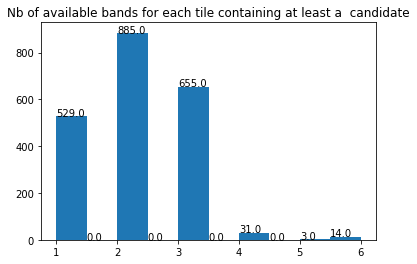

In [57]:
plt.title('Nb of available bands for each tile containing at least a  candidate')

data=flatten(nb_of_bands)
arr=plt.hist(data)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

## 3.3 Visualization of candidates and all tiles on the sky

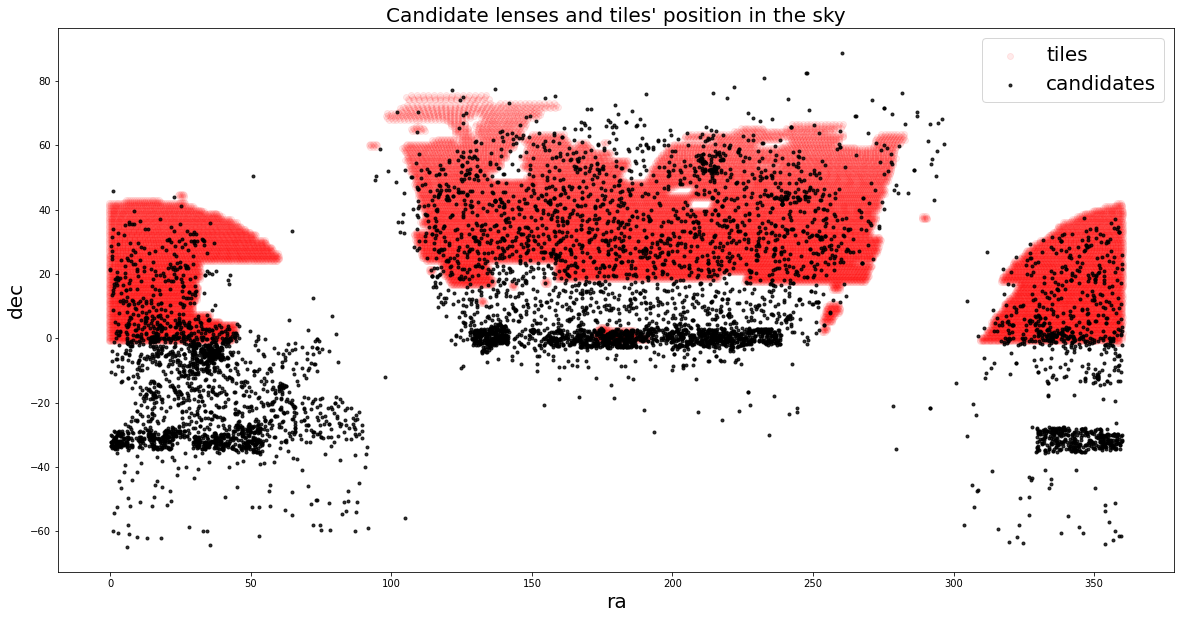

In [152]:
plt.figure(figsize = [20,10])
plt.scatter(tiles_table['RA_0'], tiles_table['DEC_0'], c = 'r', alpha = 0.08, label = 'tiles' )
plt.scatter(all_lenses['RA'], all_lenses['DEC'], marker = '.',c = 'k', alpha = 0.8, label = 'candidates')
plt.title("Candidate lenses and tiles' position in the sky", fontsize = 20)
plt.legend(fontsize = 20)
plt.ylabel('dec', fontsize = 20)
plt.xlabel('ra', fontsize = 20);

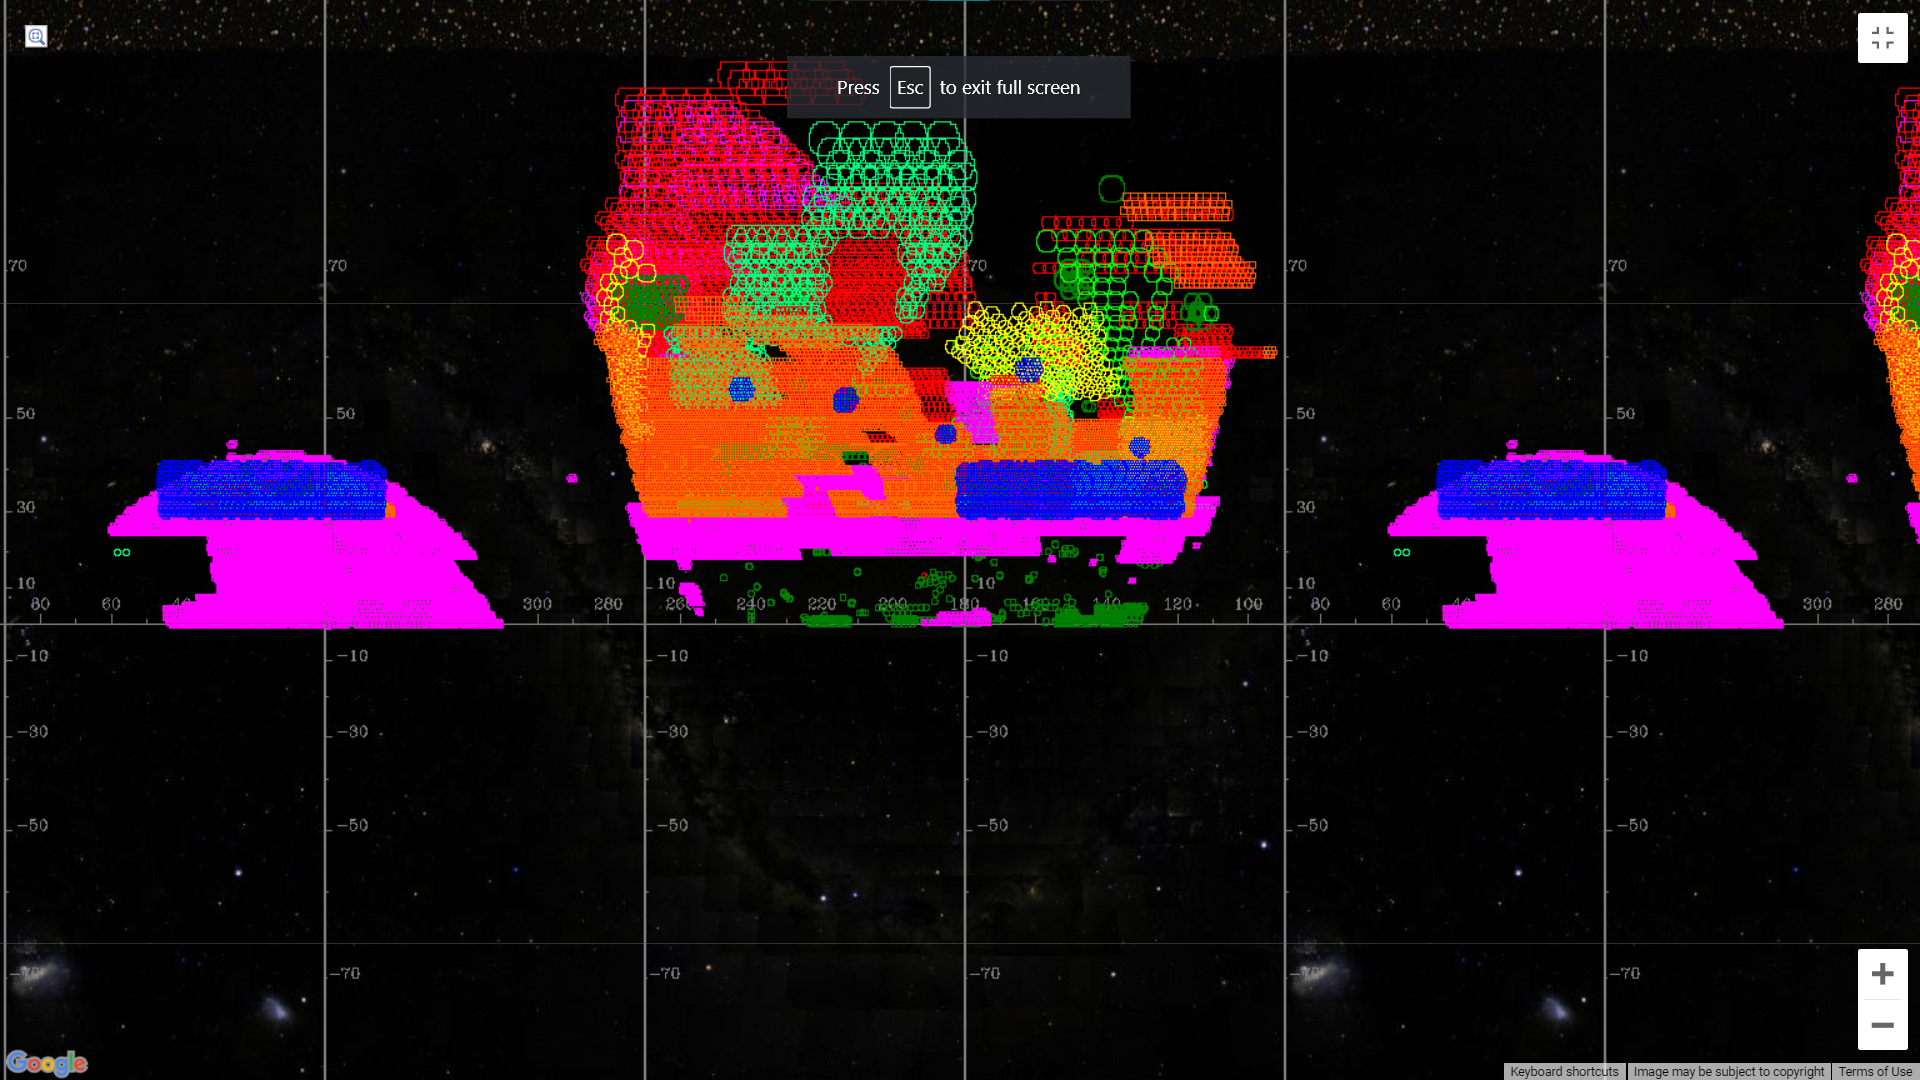

In [162]:
bands = list(tiles_table.keys())[2:8] #leaving hcs_z out
bands

['CFIS_u', 'CFIS_r', 'PS1_g', 'PS1_i', 'PS1_z', 'HCS_g']

In [165]:
def in_tile(row):
    i = 0
    for band in bands:
        if row[band] != 0:
            i += 1
    return i
tiles_table['band_nb'] = tiles_table.apply(lambda row: in_tile(row), axis = 1)

In [176]:
#tiles_table.to_csv(label_dir + 'tiles_summary.csv')

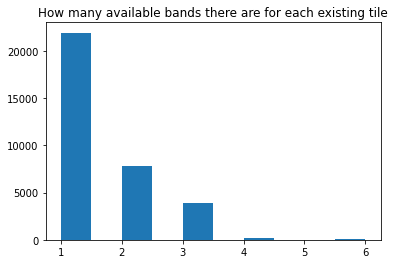

In [174]:
plt.title('How many available bands there are for each existing tile')
plt.hist(tiles_table['band_nb']);